# Project: Supervised Learning
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, recall_score, accuracy_score, f1_score, precision_score
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

## 1) Download and Prepare Data
---

In [2]:
df = pd.read_csv('Churn.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [4]:
# Filling Null values in the Tenure column with the column mean

df['Tenure'] = df['Tenure'].fillna(df['Tenure'].mean())
df['Tenure'].mean()

4.997690023099746

In [5]:
# Dropping surname column as it is irrelevent to the model since most will be unique
# This also keeps the dataframe from getting much larger
# Also dropping the Row Number and CustomerID columns as they are not relevant to the model

df = df.drop('Surname', axis=1)
df = df.drop('RowNumber', axis=1)
df = df.drop('CustomerId', axis=1)

In [6]:
# One hot encoding to prepare all of the features for training my model, drop first to keep the dataframe concise

df2 = pd.get_dummies(df, drop_first=True)
df2.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


In [7]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  float64
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Exited             10000 non-null  int64  
 9   Geography_Germany  10000 non-null  uint8  
 10  Geography_Spain    10000 non-null  uint8  
 11  Gender_Male        10000 non-null  uint8  
dtypes: float64(3), int64(6), uint8(3)
memory usage: 732.5 KB


In [8]:
# Split data into train, validate, and test data (60/20/20)

train, val = train_test_split(df2, test_size=0.4, random_state=1)
valid, test = train_test_split(val, test_size=0.5, random_state=2)

print(train.shape)
print(valid.shape)
print(test.shape)

(6000, 12)
(2000, 12)
(2000, 12)


In [9]:
# Define our feature and target variables for each split section

train_feat = train.drop('Exited', axis=1)
train_target = train['Exited']

val_feat = valid.drop('Exited', axis=1)
val_target = valid['Exited']

test_feat = test.drop('Exited', axis=1)
test_target = test['Exited']

##### Above when preprocessing the data, I took the following steps:
- Filled missing vlaues in the tenure column with the column mean
- Dropped the surname column as they a mostly unique and unnecessary for the model. This column would also expand by thousands if used in the next step (OHE)
- Used one hot encoding to converst all non numerical variables to numbers
- Split the data into training, validating, and testing datasets
- split each set into targets and feature variables

## 2) Examine the balance of classes. Train the model without taking into account the imbalance.
---

In [10]:
class_frequency = df2['Exited'].value_counts(normalize=True)
class_frequency

0    0.7963
1    0.2037
Name: Exited, dtype: float64

##### There is an imbalance in the data where nearly 80% of customers have left, making up the large majority of the target variable

In [11]:
# Unbalanced Model

i_model = LogisticRegression(random_state=123)
i_model.fit(train_feat, train_target)
i_pred = i_model.predict(val_feat)
i_recall = recall_score(val_target, i_pred)
i_prec = precision_score(val_target, i_pred)
i_f1 = f1_score(val_target, i_pred)
print('Recall:', i_recall)
print('Precision:', i_prec)
print('F1 Score:', i_f1)

Recall: 0.0340632603406326
Precision: 0.2916666666666667
F1 Score: 0.06100217864923747


##### The model with the imbalanced data performs has an extremely low F1 score. I can balance the data by:
- Upsampling the churned customers
- Downsampling the retained customers
- Balancing the class_weight in the model
- Adjusting the threshold

## 3) Improve the quality of the model. Explore a couple ways of fixing the class imbalance
---

##### Upsampling:

In [12]:
def upsample(feats, target, repeat):
    feat_zeros = feats[target == 0]
    feat_ones = feats[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    feat_upsampled = pd.concat([feat_zeros] + [feat_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    feat_up, target_up = shuffle(feat_upsampled, target_upsampled, random_state=12345)
    return feat_up, target_up


feat_up, target_up = upsample(train_feat, train_target, 4)
print(feat_up.shape)
print(target_up.shape)

(9588, 11)
(9588,)


In [13]:
# Retrain and validate the model with the upsampled training data

u_model = LogisticRegression(random_state=123, solver='liblinear')
u_model.fit(feat_up, target_up)
u_pred = u_model.predict(val_feat)
u_recall = recall_score(val_target, u_pred)
u_prec = precision_score(val_target, u_pred)
u_f1 = f1_score(val_target, u_pred)
print('Recall:', u_recall)
print('Precision:', u_prec)
print('F1 Score:', u_f1)

Recall: 0.6666666666666666
Precision: 0.34815756035578144
F1 Score: 0.4574290484140233


Upsampling significantly improve the F1 metric from 0.06 to 0.45

##### Class Weight balancing

In [14]:
b_model = LogisticRegression(random_state=123, solver='liblinear', class_weight='balanced')
b_model.fit(train_feat, train_target)
b_pred = i_model.predict(val_feat)
b_recall = recall_score(val_target, b_pred)
b_prec = precision_score(val_target, b_pred)
b_f1 = f1_score(val_target, b_pred)
print('Recall:', b_recall)
print('Precision:', b_prec)
print('F1 Score:', b_f1)

Recall: 0.0340632603406326
Precision: 0.2916666666666667
F1 Score: 0.06100217864923747


Not seeing any difference here between the original model and this one with the class_weight='balanced' parameter

##### Threshold Testing

In [15]:
t_model = LogisticRegression(random_state=1234, solver='liblinear')

t_model.fit(train_feat, train_target)
prob_val = t_model.predict_proba(val_feat)
prob_one_val = prob_val[:, 1]

for threshold in np.arange(0.1, 0.26, 0.02):
    pred_v = prob_one_val > threshold
    prec = precision_score(val_target, pred_v)
    recall = recall_score(val_target, pred_v)
    f1 = f1_score(val_target, pred_v)

    print("Threshold = {:.2f} | Precision = {:.3f} | Recall = {:.3f} | F1: {:.3f}".format(
        threshold, prec, recall, f1))

Threshold = 0.10 | Precision = 0.217 | Recall = 0.978 | F1: 0.355
Threshold = 0.12 | Precision = 0.226 | Recall = 0.942 | F1: 0.365
Threshold = 0.14 | Precision = 0.240 | Recall = 0.893 | F1: 0.379
Threshold = 0.16 | Precision = 0.254 | Recall = 0.813 | F1: 0.387
Threshold = 0.18 | Precision = 0.263 | Recall = 0.713 | F1: 0.384
Threshold = 0.20 | Precision = 0.279 | Recall = 0.628 | F1: 0.386
Threshold = 0.22 | Precision = 0.301 | Recall = 0.545 | F1: 0.388
Threshold = 0.24 | Precision = 0.323 | Recall = 0.465 | F1: 0.381


The best Threshold in this case is 0.22 giving an F1 score of .388

## 4) Finalize best model. Perform final testing
---

In [16]:
# Data to use:

# Training: feat_up, target_up
# Validating: val_feat, val_target
# Testing: test_feat, test_target

#### Logistic Regression

F1 Score: 0.4574290484140233
AUC-ROC: 0.7232141900137655


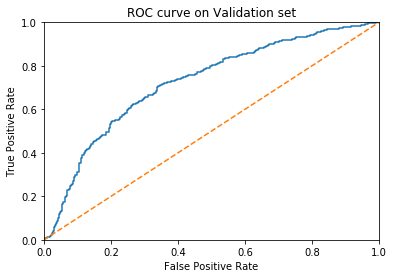

In [17]:
model = LogisticRegression(random_state=123, solver='liblinear')
model.fit(feat_up, target_up)
preds = model.predict(val_feat)
prob_v = model.predict_proba(val_feat)
prob_one_v = prob_v[:, 1]
auc_roc = roc_auc_score(val_target, prob_one_v)

print('F1 Score:', f1_score(val_target, preds))
print('AUC-ROC:', auc_roc)

# Creating and plotting ROC curve
fpr, tpr, thresholds = roc_curve(val_target, prob_one_v)

plt.figure()
plt.plot(fpr, tpr)

# Random Model straight line
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve on Validation set')
plt.show()

##### Random Forest Regressor

In [18]:
for n in range(10, 16, 1):
    mod = RandomForestClassifier(random_state=1, max_depth=n)
    mod.fit(feat_up, target_up)
    p = mod.predict(val_feat)
    print('Depth:', n, 'F1:', f1_score(val_target, p))

Depth: 10 F1: 0.6342015855039638
Depth: 11 F1: 0.6503496503496502
Depth: 12 F1: 0.6408706166868198
Depth: 13 F1: 0.6115288220551379
Depth: 14 F1: 0.6383526383526383
Depth: 15 F1: 0.6137566137566137


In [19]:
for x in range(150, 201, 10):
    mod = RandomForestClassifier(random_state=1, max_depth=11, n_estimators=x)
    mod.fit(feat_up, target_up)
    p = mod.predict(val_feat)
    print('Estimators:', x, 'F1:', f1_score(val_target, p))

Estimators: 150 F1: 0.6573426573426574
Estimators: 160 F1: 0.6549707602339181
Estimators: 170 F1: 0.6549707602339181
Estimators: 180 F1: 0.6526315789473683
Estimators: 190 F1: 0.655011655011655
Estimators: 200 F1: 0.6495327102803738


In [20]:
# Final Model: Random Forest Classifier

model_rf = RandomForestClassifier(random_state=1, max_depth=11, n_estimators=150)
model_rf.fit(feat_up, target_up)

# Predict and score with test data
pred = model_rf.predict(test_feat)
prob_t = model_rf.predict_proba(test_feat)
prob_one_t = prob_t[:, 1]
auc_roc = roc_auc_score(test_target, prob_one_t)

print('F1 Score:', f1_score(test_target, pred))
print('AUC-ROC:', auc_roc)

F1 Score: 0.6170921198668146
AUC-ROC: 0.8494445267367798


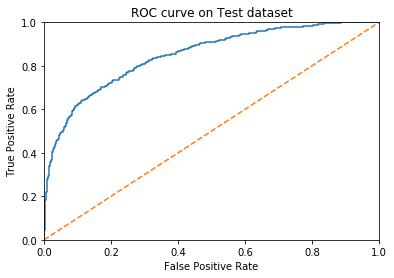

In [21]:
# Creating and plotting ROC curve
fpr, tpr, thresholds = roc_curve(test_target, prob_one_t)

plt.figure()
plt.plot(fpr, tpr)

# Random Model straight line
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve on Test dataset')
plt.show()

## Conclusion:
---

- My final model ended up being a Random Forest Classifier.
- The parameters I tuned were the max_depth=11 and the n_estimators=150.
- Final F1 Score of 0.617 on the test data set.
- Final AUC-ROC score of 0.849.